In [19]:
import pandas as pd
from sklearn import preprocessing
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from modules.gnnad.graphanomaly_cleaned import GNNAD
from modules.preprocessing_modules.data_preprocessing import Data_Formatter, Data_Preprocessor

## Load data

In [20]:
try:
    df_loaded
except NameError: # read in training data
    # read in test data
    df_loaded = pd.read_csv("DASIV04.csv")
    df_loaded = Data_Formatter(df_loaded).df
    
df = df_loaded.copy()

In [21]:
model_params = {}
model_params['threshold_type'] = "percentile"    # "percentile" or "max_validation"
model_params['percentile'] = 99.99
model_params['epoch'] = 50
model_params['topk'] = 11                        # 11 seems to work the best. number of top-k neighbors to consider for each node when creating the learned graph structure
model_params['errors_topk'] = 7                  # 7 seems to work the best. Number of top-k errors to consider for detecting anomalies
model_params['slide_win'] = 15                   # Window size. 15 seems to work well
model_params['slide_stride'] = 2                 # Stride size. 2 seems to work well
model_params['device'] = "cuda"
model_params['shuffle_train'] = True             # Shuffles the training set after validation set was created, False seems to work better
model_params['smoothen_error'] = True            # Smoothen the error scores. True seems to work better
model_params['validation_size'] = 144
model_params['batch'] = 256                      # 256 seems to work well
model_params['early_stop_win'] = 20
model_params['loss_func'] = "mse"                # "mse" or "mae". MSE seems to work better overall.
model_params['use_deterministic'] = False
model_params['input_column_names'] = df.columns.tolist() 

In [22]:
import warnings

# Ignore specific user warnings about non-deterministic operations
warnings.filterwarnings("ignore", message="scatter_reduce_cuda does not have a deterministic implementation")

In [23]:
scaler = preprocessing.RobustScaler()

test_size = 432 # 432 is 3 days of data
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.index = df["timestamp"]

test_start = pd.to_datetime("2024-06-01 00")

test_end = test_start + pd.Timedelta(days=1)
train, test = df[:test_start], df[test_start:test_end] 

train_processed = Data_Preprocessor(train, scaler=scaler, train_data=True).df
test_processed = Data_Preprocessor(test, scaler=scaler).df

test_prev_day_start = test_start - pd.Timedelta(days=1)
test_prev_day_end = test_start
test_prev_day = df[test_prev_day_start:test_prev_day_end]

In [24]:
train_processed

,r_phase_current,s_phase_current,t_phase_current,pv_current,pv_voltage,generated_power,pv_generated_power,horizontal_solar_radiation,vertical_solar_radiation,module_temperature,outdoor_temperature,rs_line_voltage,st_line_voltage,tr_line_voltage
timestamp,,,,,,,,,,,,,,
2023-09-08 06:00:00,-0.473334,-0.495394,-0.505152,-0.354423,-0.477822,-0.408843,-0.351724,-0.390995,-0.327599,-0.261786,-0.000268,-1.147294,-1.108761,-1.040210
2023-09-08 06:10:00,-0.396367,-0.425917,-0.426888,-0.354423,-2.672415,-0.404321,-0.351724,-0.388793,-0.327282,-0.248194,0.016333,-1.119874,-1.136111,-1.051136
2023-09-08 06:20:00,-0.394170,-0.425024,-0.422618,-0.354423,-2.677264,-0.398250,-0.351724,-0.379915,-0.321979,-0.247507,0.018047,-1.173502,-1.161111,-1.053977
2023-09-08 06:30:00,-0.389101,-0.421535,-0.416975,-0.354357,-2.560151,-0.390990,-0.351344,-0.370442,-0.314458,-0.243008,0.018690,-1.252366,-1.241667,-1.125000
2023-09-08 06:40:00,-0.382934,-0.417072,-0.408815,-0.350071,-1.792447,-0.378255,-0.346935,-0.361108,-0.307369,-0.236144,0.020403,-1.249211,-1.241667,-1.130682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:30:00,-0.370261,-0.402223,-0.406223,-0.354423,-1.639050,-0.397298,-0.351724,-0.380159,-0.322642,-0.078283,0.241894,-0.501577,-0.500000,-0.531250
2024-05-31 19:40:00,-0.373725,-0.406362,-0.412628,-0.354423,-1.873995,-0.407058,-0.351724,-0.390856,-0.327599,-0.104974,0.227113,-0.542587,-0.608333,-0.613636
2024-05-31 19:50:00,-0.372964,-0.405956,-0.413772,-0.354423,-1.522834,-0.408843,-0.351724,-0.390995,-0.327599,-0.107567,0.218224,-0.488959,-0.558333,-0.514205


In [25]:
df = df_loaded.copy()
# Store results

train_processed = train_processed.reset_index(drop=True)

# Number of splits (folds)
window_size=model_params['slide_win']
n_steps = len(test_processed) - window_size - 1

# Initialize the model
model = GNNAD(**model_params)
model.fit(train_processed)

KeyError: "['timestamp'] not in index"

In [13]:
# Iterate over the metrics in the JSON data
def sum_drift_scores(report):
    total_drift_score = 0
    for metric in report['metrics']:
        if metric['metric'] == 'DataDriftTable':
            # Extract the drift scores from the 'drift_by_columns' dictionary
            drift_by_columns = metric['result']['drift_by_columns']
            for column_data in drift_by_columns.values():
                drift_score = column_data['drift_score']
                total_drift_score += drift_score
                
    return total_drift_score

In [14]:
model.threshold

AttributeError: 'GNNAD' object has no attribute 'threshold'

In [ ]:
error_sums = []
drift_scores = []
predictions = []

for step in range(n_steps):
    test_start = step
    test_end = step + window_size + 1
    test_set = test_processed.iloc[test_start:test_end]
    
    pred_labels = model.predict(test_set)
    error_sum = model.test_avg_loss
    error_sums.append(error_sum)
    predictions.append(pred_labels)
    print(pred_labels)
    if len(pred_labels) == 0:
        print("The list is empty")

    report = Report(metrics=[DataDriftPreset()])
    report.run(reference_data=train_processed[:-144], current_data=test_set)
    # Save the report as an HTML file

    # Get the dataset drift score
    drift_score = sum_drift_scores(report.as_dict())
    drift_scores.append(drift_score)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


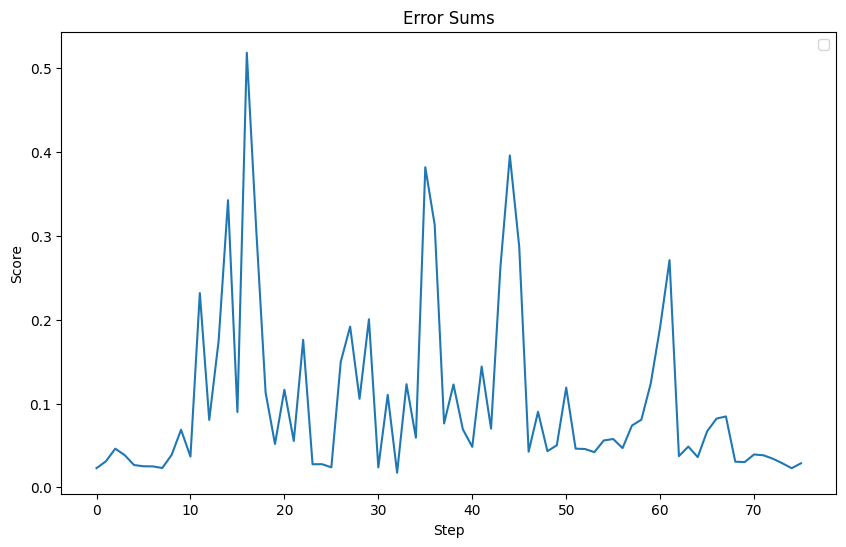

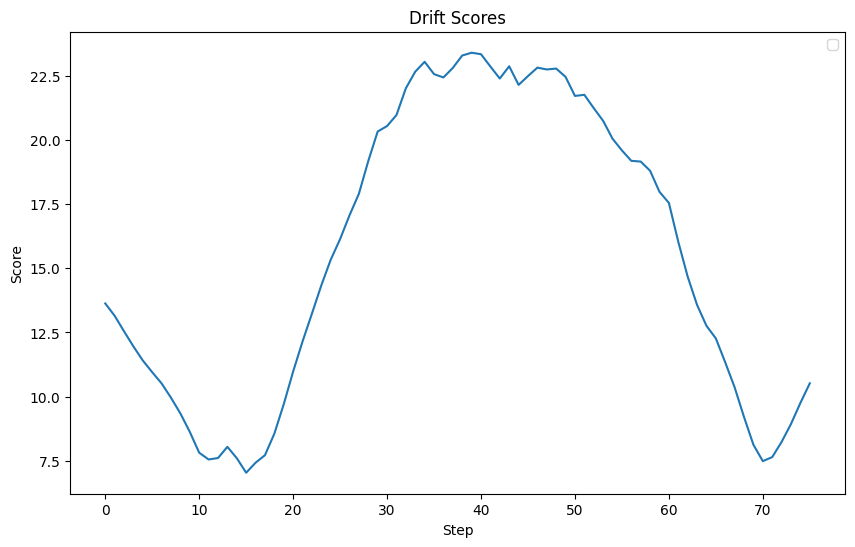

In [ ]:
import matplotlib.pyplot as plt

# Visualize error_sums and drift_scores
plt.figure(figsize=(10, 6))
plt.plot(error_sums)
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Error Sums')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(drift_scores)
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Drift Scores')
plt.legend()
plt.show()
